# **Introduction**

International Essentials is an international supermarket chain.

Shoppers at their supermarkets can sign up for a loyalty program that provides rewards each year to customers based on their spending. The more you spend the bigger the rewards. 

The supermarket would like to be able to predict the likely amount customers in the program will spend, so they can estimate the cost of the rewards. 

This will help them to predict the likely profit at the end of the year.  

I have been provided with 3 datasets.  
The first one is the first one I received. I have first cleaned up the data and then performed an EDA. This EDA led to some suggestions to the team of where and how we could improve this loyalty program to encourage the customers to spend more.  
I received the second and third dataset at the same time. They were already clean however the third dataset (called test dataset) didn't have the 'spend' column. That is the target variable.  
Originally the excercise was to use the second dataset to fit the chosen model with in order to predict the 'spend' of the third dataset. However, I wanted to put myself in a more realistic context where I questioned the validity of the first analysis to find the best model to use and which dataset to use to train the model.  
I found that although both datasets performed very well with the Linear Regression model, training one with one dataset and predicting with the other gave terrible scores. Importantly, combining both dataset gave a poor performance with Linear Regression model. This suggests that both datasets have drastic different distribution of features and target variables.  
Hence, how can I be so sure (or trust) the team that the second dataset is the one to use to train the Linear Regression model to predict the 'spend' of the third dataset?  
I therefore look for an ensemble model and compared its predictions with the predictions made with the Linear Regression model trained with the second dataset (the one I was supposed to use in the excersise, the one that had an excellent performance due to overfitting). I found a Bagging regressor model that gave predictions very close to the artificially perfect Liear Regression model. 

In [1]:
#Pakages for the EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import calendar
from scipy.stats import mannwhitneyu, kruskal
from statsmodels.stats.proportion import proportions_ztest


In [2]:
customer_data = pd.read_csv("loyalty.csv")
print(customer_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           1246 non-null   int64  
 1   spend                 1246 non-null   float64
 2   first_month           1246 non-null   object 
 3   items_in_first_month  1246 non-null   int64  
 4   region                1246 non-null   object 
 5   loyalty_years         1246 non-null   object 
 6   joining_month         1121 non-null   object 
 7   promotion             1246 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 78.0+ KB
None


# **Checking the data columns by column**  
First I am checking the data accordingly to what we should expect.  
We can already see in the table above that there are missing data in 'joining_month'.  
 
## **customer_id**  
All the values should be unique.  


In [3]:
print(len(customer_data["customer_id"].unique()))
len(customer_data)

1246


1246

## **spend**  
Continuous. </br>The total spend of the customer in their last full year. This can be any positive value to two decimal places. </br>Missing values should be replaced with 0. 

In [4]:
print(customer_data["spend"].describe())

count    1246.000000
mean      122.637119
std         9.975102
min       104.290000
25%       112.210000
50%       123.840000
75%       131.092500
max       142.290000
Name: spend, dtype: float64


There are no missing values and no 0 (the minimum is 104.29).  
Furthermore, it seems that the values are all rounded to 2 decimals (see the median).  
However, just to be sure I will round to 2 decimals the column.  

In [5]:
customer_data["spend"] = customer_data["spend"].round(2)

## **first_month**  
Continuous. </br>The amount spent by the customer in their first month of the year. This can be any positive value, rounded to two decimal places. </br>Missing values should be replaced with 0.  

Based on the general info, this column is an object type (string). It should be a float.  

In [6]:
print(customer_data["first_month"].value_counts(dropna=False))
print(customer_data["first_month"].isna().sum())

first_month
.        125
21.38     12
21.33     10
21.35      9
21.39      9
        ... 
15.71      1
25.28      1
24.41      1
19.95      1
26.18      1
Name: count, Length: 491, dtype: int64
0


There are no missing values, but the reason of the type 'object' is the ".". I will replace it to 0 and change to float type.

In [7]:
customer_data["first_month"].replace(".",None, inplace=True)
customer_data["first_month"] = customer_data["first_month"].astype(float)
customer_data["first_month"].fillna(0, inplace=True)
print(customer_data["first_month"].describe())

count    1246.000000
mean       17.161998
std         6.583749
min         0.000000
25%        15.750000
50%        19.125000
75%        21.280000
max        26.200000
Name: first_month, dtype: float64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\2959011451.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data["first_month"].replace(".",None, inplace=True)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\2959011451.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [8]:
customer_data["first_month"] = customer_data["first_month"].round(2)
print(customer_data["first_month"].describe())

count    1246.000000
mean       17.161998
std         6.583749
min         0.000000
25%        15.750000
50%        19.125000
75%        21.280000
max        26.200000
Name: first_month, dtype: float64


## **items_in_first_month**
Discrete. </br>The number of items purchased in the first month. Any integer value greater than or equal to zero. </br>Missing values should be replaced by 0.  

Based on the general info, the type is integer so it's a good type. Furthermore there are no missing values. So let's see if we have 0. If we do not have 0, I will have to compare with the customers who have spent nothing in the first month.  

In [9]:
print(customer_data["items_in_first_month"].describe())

count    1246.000000
mean        9.418138
std         3.000288
min         5.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        15.000000
Name: items_in_first_month, dtype: float64


Humm...We do not have any 0 as minimum. I will go back to it in the next chapter. For now I am only doing a general scrolling.  

## **region**
Nominal. </br>The geographic region that the customer is based in. One of four values Americas, Asia/Pacific, Europe, Middle East/Africa. </br>Missing values should be replaced with "Unknown".  
In the general info this column is an object. So far so good.  

In [10]:
print(customer_data["region"].value_counts(dropna=False))

region
Middle East/Africa    326
Europe                320
Americas              309
Asia/Pacific          291
Name: count, dtype: int64


Everything seems in Ordnung. So I will switch to categorical to gain some space.  

In [11]:
customer_data["region"] = customer_data["region"].astype("category")

## **loyalty_years**  
Ordinal. </br>The number of years the customer has been a part of the loyalty program. One of five ordered categories, '0-1', '1-3', '3-5', '5-10', '10+'. </br>Missing values should be replaced with '0-1'.  
Right now the column is an object and needs to be changed into an ordered categorical type.  

In [12]:
print(customer_data["loyalty_years"].value_counts(dropna=False, sort=False))

loyalty_years
5-10    250
0-1     382
10+     117
3-5     256
1-3     241
Name: count, dtype: int64


I have to switch to categories. Right now they are not ordered at all.  

In [13]:
customer_data["loyalty_years"] = customer_data["loyalty_years"].astype("category")
new_categories = ["0-1","1-3","3-5","5-10","10+"]
customer_data["loyalty_years"] = customer_data["loyalty_years"].cat.reorder_categories(new_categories=new_categories, ordered=True)
print(customer_data["loyalty_years"].value_counts(sort=False))

loyalty_years
0-1     382
1-3     241
3-5     256
5-10    250
10+     117
Name: count, dtype: int64


## **joining_month**  
Nominal. </br>The month the customer joined the loyalty program. One of 12 values "Jan", "Feb", "Mar", "Apr", etc. </br>Missing values should be replaced with "Unknown". We saw in the table info that we have 1121 non-null data so there are 125 missing values.

In [14]:
customer_data["joining_month"].fillna("Unknown", inplace=True)
ordered_month = ['Unknown', "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
customer_data["joining_month"] = customer_data["joining_month"].astype("category")
customer_data["joining_month"] = customer_data["joining_month"].cat.reorder_categories(new_categories=ordered_month\
                                                                                       , ordered=True)

print(customer_data["joining_month"].value_counts(sort=False, dropna=False))



joining_month
Unknown    125
Jan        146
Feb        109
Mar         85
Apr         93
May         96
Jun         75
Jul        111
Aug         91
Sep         88
Oct        107
Nov         75
Dec         45
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\3620783704.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data["joining_month"].fillna("Unknown", inplace=True)


## **promotion**
Nominal. </br>Did the customer join the loyalty program as part of a promotion? Either 'Yes' or 'No'. </br>Missing values should be replaced with 'No'.

In [15]:
print(customer_data["promotion"].value_counts(dropna=False))

promotion
No     572
Yes    549
NO      63
YES     62
Name: count, dtype: int64


We have some typo problems. Let's clean this up.

In [16]:
customer_data["promotion"] = customer_data["promotion"].str.title()
print(customer_data["promotion"].value_counts())

promotion
No     635
Yes    611
Name: count, dtype: int64


# **EDA (Exploratory Data Analysis)**  
Now I have cleaned up every column, I will do an EDA.  
Notably, I will focus on 'first_month' where there are a non-negligeable amount of customers who spent 0 in their first month while every customers got at least 5 items in their first-month. The other column we need to focus on is 'joining_month' where there are 125 "Unknown" month. Do we keep them as "Unknown"? Do we remove them or do we inpute them (with the mode or other)?    

## **The customers who haven't spent a dime in their first month**  

10% of our customers have spent nothing in their 1st month of the year although they did get stuffs since I do not have 0 items bought in the first month.  
The question we can therefore ask is: Is that a mistake or have they took full advantage of their yearly reward?  
Therefore, to compare this category of customers with the others, I am creating a column called 'rewarded_vs_not' that contains 2 categories:  
- "rewarded" : the group of customers who took full advantage of their reward and didn't spend a dime on their first month;  
- "invested" : the group of customers who still paid something on their first month.  

In [17]:
customer_data["rewarded_vs_not"] = np.where(customer_data["first_month"] == 0, "rewarded", "invested")
print(customer_data.groupby("rewarded_vs_not")["spend"].describe())

                  count        mean        std     min     25%     50%  \
rewarded_vs_not                                                          
invested         1121.0  122.575513  10.034816  104.29  112.19  123.84   
rewarded          125.0  123.189600   9.443026  104.50  112.50  124.73   

                    75%     max  
rewarded_vs_not                  
invested         130.99  142.29  
rewarded         131.18  141.85  


Contrary to what I was expecting, I do not see any obvious difference in the year spending between the two groups, suggesting that their reward is not higher than the others (remember that more they spend, higher is the reward).  
I can make a quick statistical test to see if that's the case (H0 = no difference of year spend; alpha = 0.05).  

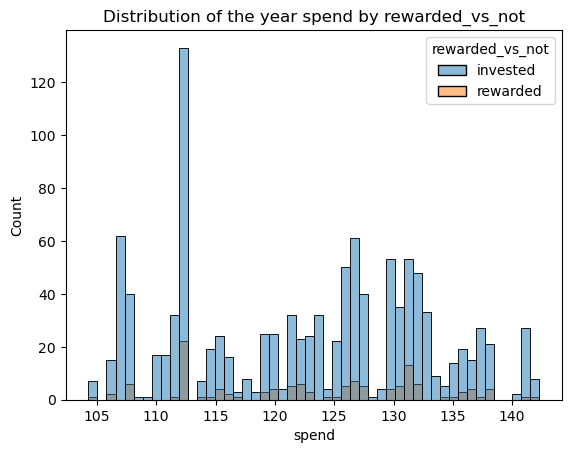

In [18]:
#look at the distribution of spend
sns.histplot(x="spend", data=customer_data, hue="rewarded_vs_not", bins=50)
plt.title("Distribution of the year spend by rewarded_vs_not")
plt.show()

The spending is not normally distributed (it looks almost like a uniform distribution), so I will use a non parametric statiscal test. Because I am comparing only 2 samples, I will use a Mann-Whitney U test.

In [19]:
alpha = 0.05
spend_U_stat, spend_U_pval = mannwhitneyu(customer_data[customer_data["rewarded_vs_not"] == "rewarded"]["spend"],\
                                          customer_data[customer_data["rewarded_vs_not"] == "invested"]["spend"])
print(f"Mann-Whitney U test p_val: {spend_U_pval:0.4f}")

Mann-Whitney U test p_val: 0.4679


There is no significant difference of the amount spend over the year between the people who took fully advantage of their rewards and the ones who haven't.  
Perhaps the ones who did spend some money on their renewal month bought more items which would have included the free ones plus others.  

### **Do the customers who spent some money on their first month, buy more items in that month?**  
The idea here is that if these customers who do not spend more than the others over a year use all their reward on their first month, they may get less items than the ones who have spent some money on their first month.  

In [20]:
print(customer_data.groupby("rewarded_vs_not")["items_in_first_month"].describe())

                  count      mean       std  min  25%  50%   75%   max
rewarded_vs_not                                                       
invested         1121.0  9.443354  3.025878  5.0  7.0  9.0  13.0  15.0
rewarded          125.0  9.192000  2.761183  5.0  7.0  9.0  11.0  14.0


Once again, I do not see any significant differences between the two groups (the median is exactly the same).

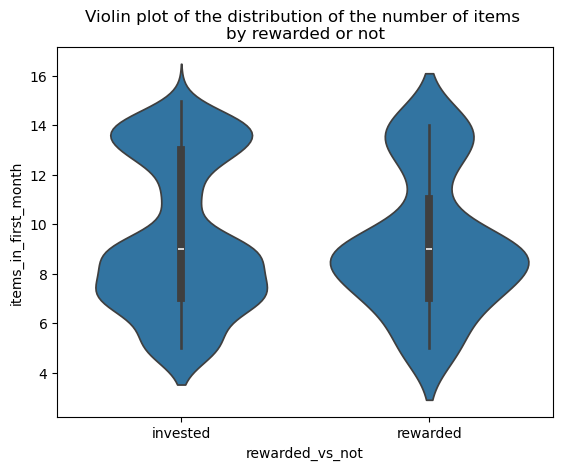

In [21]:
sns.violinplot(x="rewarded_vs_not", y="items_in_first_month", data=customer_data)
plt.title("Violin plot of the distribution of the number of items \nby rewarded or not")
plt.show()

However, the violin plot shows 2 groups of number of items in both "invested" and "rewarded" subpopulations. As shown in the table, the median (white line) is exactly the same.  
However, among the minorities who bought more than 10 items, the population seems slightly larger in the invested customers (the ones who did spend some money on their first month). Question would be therefore to test whether the proportion of n_items > 10 in the "invested" subpopulation is significantly higher than the one in the "rewarded" subpopulation. 
I will do a proportion test.  
H0 = the proportion of items > 10 is the same between rewarded and invested.  
H1 = the proportion of items > 10 in the rewarded population is lower than in the invested.  
alpha = 0.05

In [22]:
customer_data["big_items_nb"] = np.where(customer_data["items_in_first_month"] > 10, ">10", "<10")
p_hats = customer_data.groupby("rewarded_vs_not")["big_items_nb"].value_counts(normalize = True)
print(p_hats)
n_big_small_items = customer_data.groupby("rewarded_vs_not")["big_items_nb"].value_counts()
print(n_big_small_items)
n_more_10 = np.array([397, 34])
n_rows = np.array([724+397, 91+34])
z_score,p_value = proportions_ztest(count=n_more_10, nobs=n_rows, alternative="larger")
print(z_score, p_value)

rewarded_vs_not  big_items_nb
invested         <10             0.645852
                 >10             0.354148
rewarded         <10             0.728000
                 >10             0.272000
Name: proportion, dtype: float64
rewarded_vs_not  big_items_nb
invested         <10             724
                 >10             397
rewarded         <10              91
                 >10              34
Name: count, dtype: int64
1.8314574062017945 0.03351614982201288


with an alpha=0.05 I can reject H0 (p=0.0335) and conclude that the proportion of people buying more than 10 items in their first month is higher in the invested population compared to the rewarded (the ones who bought stuff only with their reward).  
However, the difference is very small (0.354 vs 0.272). Some improvements should be done to encourage the customers to use their rewards AND buy stuff with real money, like perhaps using their rewards to buy expensive stuff with an additional offer but where they still do have to pay. Maybe like getting extra reward points if you use all your reward points on a Tv only if you have to complement with actual money. If you use all your reward points without complementation you'll get no points.

## **The "Unknown" of the 'joining_month'.**
What shoud we do with the "unknown" category in the 'joining_month?  


In [23]:
customer_data["joining_month"].value_counts(normalize=True)

joining_month
Jan        0.117175
Unknown    0.100321
Jul        0.089085
Feb        0.087480
Oct        0.085875
May        0.077047
Apr        0.074639
Aug        0.073034
Sep        0.070626
Mar        0.068218
Jun        0.060193
Nov        0.060193
Dec        0.036116
Name: proportion, dtype: float64

This category is 2nd in the list and represents 10% of our sample. Hence, we cannot ignore it.

Text(0.5, 1.0, 'Average of year spend per joining month')

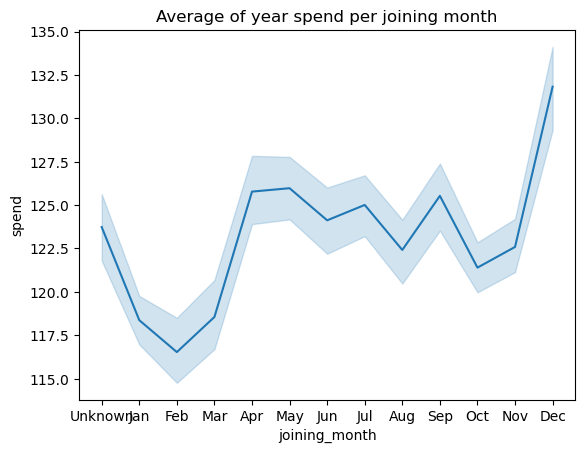

In [24]:
the_unknown = customer_data[customer_data["joining_month"] == "Unknown"]
sns.lineplot(x="joining_month", y="spend", data=customer_data)
plt.title("Average of year spend per joining month")

I cannot inpute this category with any other month based on the spend.  
Indeed, we can see 3 periods:  
- January to Mars. The customers who joined the membership in this period are the ones who spend the least in their year;  
- April to November. The customers who joined the membership in this spend roughly a similar amount in their year with the exception of April (perhaps du to Easter);  
- December seems the most fruitful joining month.  
The "unknown" group is in the same range of spend as April to November. I could potentially design a predictive model using joining month as target variable to predict the joining month in the "Unknown" group. However, I have a very good score (R²) in my predictive model (where spend is the target varaible) when I keep this category as it is. So I will not change it.  

## **Does loyalty pay off (to our advantage of course)?**
The team at International Essentials have told me that they have always believed that the number of years in the loyalty scheme is the biggest driver of spend.  
Let's see if they have a good instinct.  

In [25]:
print(customer_data.groupby("loyalty_years")["spend"].describe())

               count        mean       std     min       25%      50%  \
loyalty_years                                                           
0-1            382.0  110.557461  3.050032  104.29  107.5625  111.815   
1-3            241.0  129.308340  3.106174  123.66  126.5200  130.200   
3-5            256.0  124.550547  3.329429  119.16  121.6975  125.110   
5-10           250.0  135.150040  3.755654  129.75  132.2400  135.565   
10+            117.0  117.411453  4.089553  111.88  114.1000  117.680   

                    75%     max  
loyalty_years                    
0-1            112.1775  118.36  
1-3            131.5700  137.47  
3-5            127.0625  131.34  
5-10           137.7375  142.29  
10+            119.9900  124.26  


C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\3689172978.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer_data.groupby("loyalty_years")["spend"].describe())


Text(0.5, 1.0, 'Boxplot of spend by the length of loyalty')

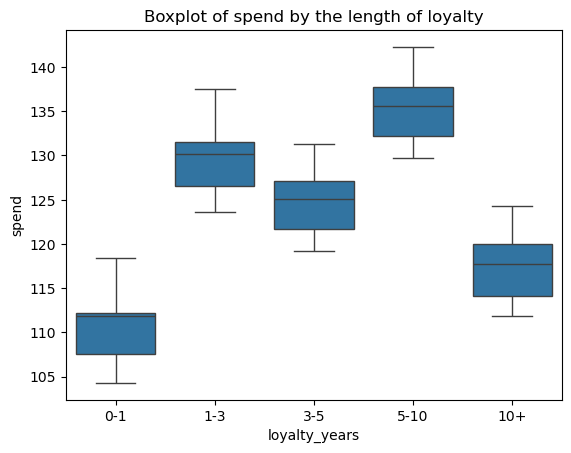

In [26]:
sns.boxplot(x="loyalty_years", y="spend", data=customer_data)
plt.title("Boxplot of spend by the length of loyalty")

The team was right and wrong.  
They were right in a sense that after a year of membership, the customers "see" the advantage of having this reward card and therefore increase dramatically their expenses with us in their year. Furthermore, we do see a significant increase (significant because 75% of the sample is above the other IQR of 1-3 and 3-5) at length 5-10 years. However, there is a "fatigue" from our customers past this time. Perhaps we should find a trategy to revitalise this population.

### **Task 2 (This is part of DataCamp excersise so I am doing it)**

The team at International Essentials have told you that they have always believed that the number of years in the loyalty scheme is the biggest driver of spend. 

Producing a table showing the difference in the average spend by number of years in the loyalty programme along with the variance to investigate this question for the team.

 - You should start with the data in the file 'loyalty.csv'.

 - Your output should be a data frame named `spend_by_years`. 

 - It should include the three columns `loyalty_years`, `avg_spend`, `var_spend`. 

 - Your answers should be rounded to 2 decimal places.  

In [27]:
spend_by_years = pd.DataFrame(customer_data.groupby("loyalty_years")["spend"].agg(avg_spend = "mean", var_spend = "var"))
spend_by_years = spend_by_years.reset_index()
spend_by_years["avg_spend"] = spend_by_years["avg_spend"].round(2)
spend_by_years["var_spend"] = spend_by_years["var_spend"].round(2)
print(spend_by_years)

  loyalty_years  avg_spend  var_spend
0           0-1     110.56       9.30
1           1-3     129.31       9.65
2           3-5     124.55      11.09
3          5-10     135.15      14.10
4           10+     117.41      16.72


C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\1453631747.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spend_by_years = pd.DataFrame(customer_data.groupby("loyalty_years")["spend"].agg(avg_spend = "mean", var_spend = "var"))


## **Does the amount spent depends on when you started your membership?**  
I have already looked at the spend by joining-month to look more closely at the "Unknown" category. However, here I am looking more at a trend (the customers behaviour) and therefore I am including the items_in_first_month and also compare "rewarded" vs "invested".  

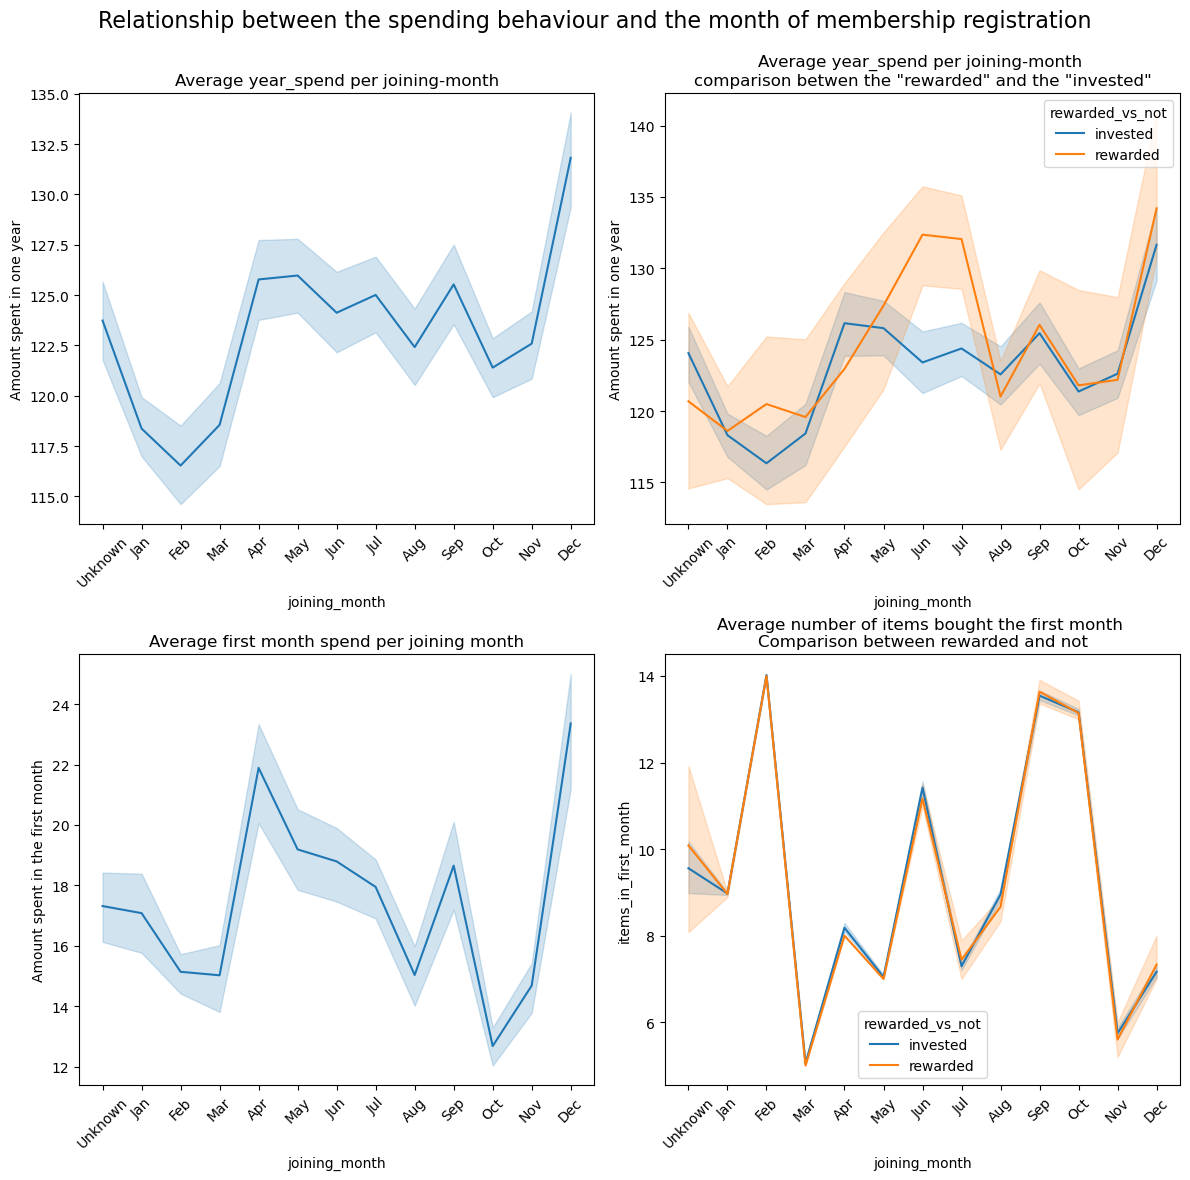

In [28]:
fig,axes = plt.subplots(2,2, figsize=(12,12))
sns.lineplot(x="joining_month", y="spend", data=customer_data, ax=axes[0,0])
sns.lineplot(x="joining_month", y="spend", data=customer_data, hue="rewarded_vs_not", ax=axes[0,1])
axes[0,0].set_title("Average year_spend per joining-month")
axes[0,1].set_title('Average year_spend per joining-month \ncomparison betwen the "rewarded" and the "invested"' )
axes[0,0].set_ylabel("Amount spent in one year")
axes[0,1].set_ylabel("Amount spent in one year")
axes[0,0].tick_params(axis="x", rotation=45)
axes[0,1].tick_params(axis="x", rotation=45)
sns.lineplot(x="joining_month", y="first_month", data=customer_data, ax=axes[1,0])
axes[1,0].set_title("Average first month spend per joining month")
axes[1,0].set_ylabel("Amount spent in the first month")
axes[1,0].tick_params(axis="x", rotation=45)
sns.lineplot(x="joining_month", y="items_in_first_month", data=customer_data, hue="rewarded_vs_not", ax=axes[1,1])
axes[1,1].set_title("Average number of items bought the first month \nComparison between rewarded and not")
axes[1,1].tick_params(axis="x", rotation=45)
plt.tight_layout()
fig.suptitle("Relationship between the spending behaviour and the month of membership registration", fontsize=16)
plt.subplots_adjust(top=0.91)
plt.show()


A lot of info here.  
Overall, the customers who are spending the most in their full membership year are the ones who joined "the club" in December (Comparison spend December with Spend Apr-Nov; p=1.27e-06). December is also the joining month where the customers buy the least number of items (with the exception of March but March is a "cheap" month). This suggests that they buy expensive stuff on average whether they use only their rewards or complement with money.  
This makes sense. In December we have two big festive events: christmas and New Year's eve.  
  February and March are clearly "doomed" months (for us) to join the loyalty membership. People who start their membership year in February-March are the ones who spend the least in their year and in their first month. Furthermore, for some reason (maybe we are doing some sale season then), customers who joined in February buy a lot of cheap products (with their rewards only or complementing with some spending but not much, about 15).  
Interestingly however, if we look more specifically at the customers who make the best of their reward card (meaning that they do not pay a dime at their anniversary membership), we can see that the ones who took their membership in summer (June-July) spend similarly in their year as the customers who joined in December (p=0.92). It would be interesting to check why is that.  

In [29]:
high_spend = customer_data[~(customer_data["joining_month"].isin(["Jan","Feb","Mar"]))]
high_spend["joining_month"] = high_spend["joining_month"].cat.remove_categories(removals=["Jan","Feb","Mar"])
not_december = high_spend[high_spend["joining_month"] != "Dec"]
not_december["joining_month"] = not_december["joining_month"].cat.remove_categories(["Dec"])
december = customer_data[customer_data["joining_month"] == "Dec"]
print(december["spend"].describe())
print(not_december["spend"].describe())

count     45.000000
mean     131.820667
std        8.403453
min      115.690000
25%      123.500000
50%      130.920000
75%      141.000000
max      141.820000
Name: spend, dtype: float64
count    861.000000
mean     124.056829
std        9.422304
min      104.290000
25%      115.520000
50%      125.720000
75%      131.600000
max      142.290000
Name: spend, dtype: float64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\1807335654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_spend["joining_month"] = high_spend["joining_month"].cat.remove_categories(removals=["Jan","Feb","Mar"])
C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\1807335654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_december["joining_month"] = not_december["joining_month"].cat.remove_categories(["Dec"])


In [30]:
#stat Mann-Whitney U
U_spendSeason_stat, U_spendSeas_pval = mannwhitneyu(december["spend"],not_december["spend"])
print(U_spendSeas_pval)

1.266614702556981e-06


In [31]:
june_july = high_spend[high_spend["joining_month"].isin(["Jun","Jul"])]
rewarded_june_july = june_july[june_july["rewarded_vs_not"] == "rewarded"]

#stats
U_rewSpend_stat, U_rewSpend_pval = mannwhitneyu(rewarded_june_july["spend"],december["spend"])
print(U_rewSpend_pval)

0.9251925526701301


## **Does the region have an effect on the spending?**

In [32]:
print(customer_data.groupby(["region","joining_month"])["spend"].describe())

C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\590728671.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer_data.groupby(["region","joining_month"])["spend"].describe())


                                  count        mean        std     min  \
region             joining_month                                         
Americas           Unknown         42.0  123.595000  10.878574  104.32   
                   Jan             40.0  117.998750   8.925397  111.73   
                   Feb             28.0  117.711429  11.102068  106.28   
                   Mar             25.0  115.380800   9.172389  107.55   
                   Apr             27.0  127.968519  10.145777  115.11   
                   May             29.0  125.821379   9.575094  112.07   
                   Jun             14.0  120.309286   9.257800  110.82   
                   Jul             27.0  123.997407   9.654384  109.71   
                   Aug             21.0  124.687143   7.322069  107.26   
                   Sep             16.0  124.011875  11.659120  112.12   
                   Oct             21.0  119.776667   8.266000  104.41   
                   Nov             16.

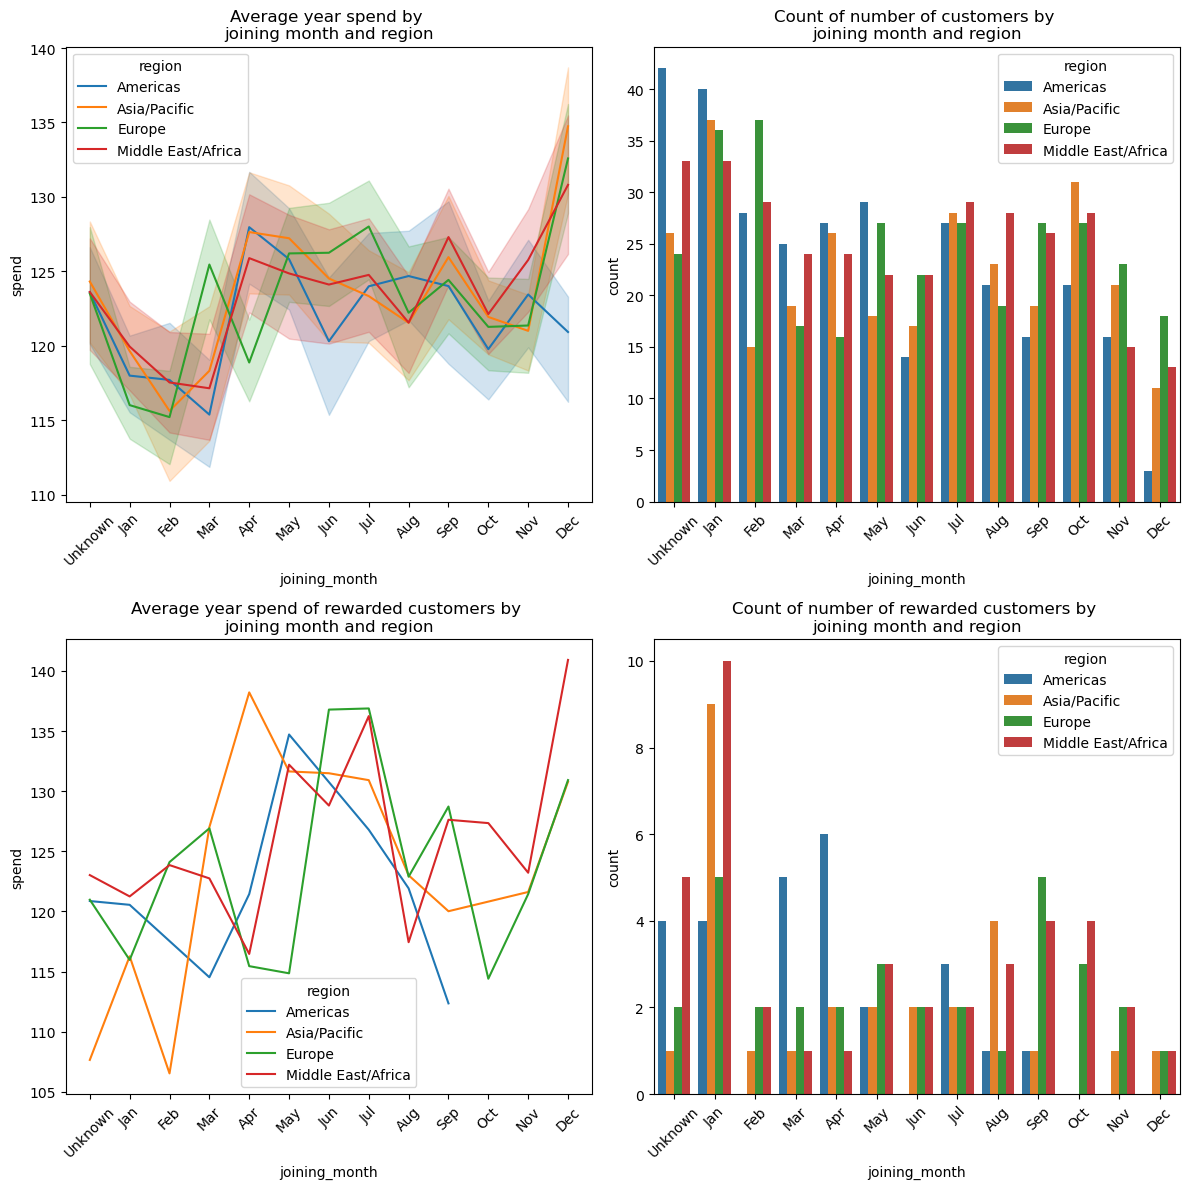

In [33]:
fig,axes = plt.subplots(2,2, figsize=(12,12))
sns.lineplot(x="joining_month", y="spend", data=customer_data, hue="region", ax=axes[0,0])
axes[0,0].set_title("Average year spend by \njoining month and region")
axes[0,0].tick_params(axis="x", rotation=45)
sns.countplot(x="joining_month", data=customer_data, hue="region", ax=axes[0,1])
axes[0,1].set_title("Count of number of customers by \njoining month and region")
axes[0,1].tick_params(axis="x", rotation=45)
sns.lineplot(x="joining_month", y="spend", data=customer_data[customer_data["rewarded_vs_not"] == "rewarded"]\
             ,hue="region", errorbar=None, ax=axes[1,0])
axes[1,0].set_title("Average year spend of rewarded customers by \njoining month and region")
axes[1,0].tick_params(axis="x", rotation=45)
sns.countplot(x="joining_month", data=customer_data[customer_data["rewarded_vs_not"] == "rewarded"]\
              ,hue="region", ax=axes[1,1])
axes[1,1].set_title("Count of number of rewarded customers by \njoining month and region")
axes[1,1].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

Naughty naughty americans...The largest group is unknown for when they joined the membership. Furthermore, only 3 american customers joined in December.  
Hence, apart from the americans who joined in December (too few to make any solid conclusion), our customers spend worldwild pretty much similarly.  
However, knowing that December is the most fruitful joining month, we should focus on making a campaign of membership in that month, especially in the american countries. America is a christian continent where Christmas and new year's are the most important gathering (family and friends) moments (along with Easter).  


In [34]:
print(customer_data["region"].value_counts())

region
Middle East/Africa    326
Europe                320
Americas              309
Asia/Pacific          291
Name: count, dtype: int64


The regional division is pretty much homegenous.

## **Is promotion a good indicator?**
A feature that I haven't looked at is 'promotion': whether the customer has joined the membership as part of a promotion.  


Text(0.5, 1.0, 'Average spend per joining month by promotion')

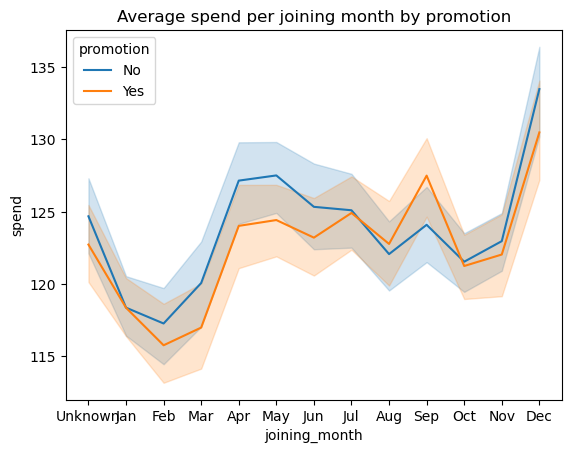

In [35]:
sns.lineplot(x="joining_month", y="spend", data=customer_data, hue="promotion")
plt.title("Average spend per joining month by promotion")

I don't think there are any significant different at all times. This is easy to check.  

<Axes: xlabel='promotion', ylabel='spend'>

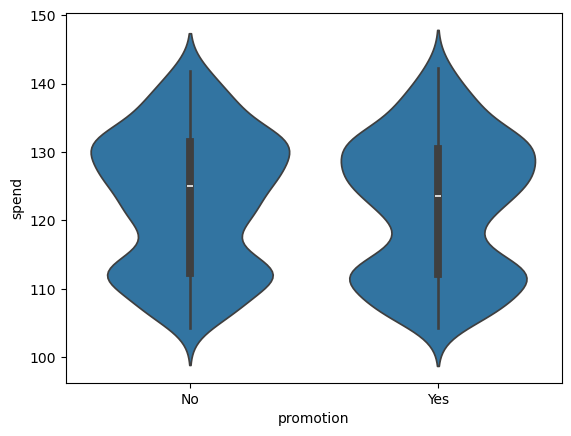

In [36]:
sns.violinplot(x="promotion", y="spend", data=customer_data)

In [37]:
alpha = 0.05
prom_U_stat,prom_U_pval = mannwhitneyu(customer_data[customer_data["promotion"] == "Yes"]["spend"]\
                                       ,customer_data[customer_data["promotion"] == "No"]["spend"])
print("Mann-Whitney U Test p_val: {}".format(round(prom_U_pval,4)))

Mann-Whitney U Test p_val: 0.0674


There is indeed no significant difference between promotion_yes and promotion_no in their spend. Furthermore, the distribution pattern of the 'spend' between the 2 groups is very similar, suggesting that this feature will have very impact on the prediction of 'spend'.   
We can remove this feature for our predictive model (target variable: 'spend').

## **Conclusion and suggestions from my EDA**  
Our supermarket *International Essentials* has a loyalty card where customers get rewards at the end of the membership year depending on their expenses with us. More you spend, bigger is the reward.  
Overall, I would suggest to find a way to encourage customers to join this loyalty program in December, as December is the joining month with the higher year spending AND also where customers consume the most (first_month). I will also focus on the Americas. Indeed, this continent is a christian continent. As such, Christmas and New year's eve are very important there. Importantly, people are willing to spend more in that period and a loyalty card will encourage them to buy even more to get a bigger reward for the next christmas. December is also the joining month where I have the least of the customers from Americas. Hence, there is a lot of space to improve there. April is also a good time to encourage joining (because of the presence of Easter).  
Another thing to improve is the length of loyalty. Yes, our team got a good instinc by saying more loyal more money you spend however, after a long period (10+) we can see a certain fatigue from our most loyal customers. We need to develop a campaign focusing on these very loyal customers. They need to feel special. Perhaps, a 10 years super big reward anniversary relative to the precedent rewards can help.  
finally, we can remove this promotion thingy as it doesn't make any difference.


# **Supervised machine learning, predictive model for 'spend' for both datasets**  
After looking at the relationships between 'spend' (our target variable) and the available features, I will now look for a useable model to predict the 'spend'. I will first use the dataset I used for my EDA (called original dataset) and then confirm that this model can be trained with the second dataset.  
However, you will see later that is not helpful in the decision of which dataset to use to train the chosen model to predict the spend for the third dataset where I no 'spend' references.

## **Feature engineering**  
I am removing the unecessary features and create one-hot encodings for my categorical data.

### **Removing unecessary features**  
I am removing customer_id (only unique values) and promotion (no difference in spend between yes and no).  
I am also removing the columns I have created for the EDA. The next dataset that I will play with my selected model doesn't contain any customers who have made full profit of their reward in their renewal month (No first_month = 0). Therefore I will compare whether these rows make a difference in the choice of the predictive model.

In [38]:
customer_data = customer_data.drop(["customer_id", "promotion","rewarded_vs_not", "big_items_nb"], axis=1)


### **One-hot encoding**

In [39]:
customers_dummies = pd.get_dummies(customer_data, drop_first=True)
print(customers_dummies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spend                      1246 non-null   float64
 1   first_month                1246 non-null   float64
 2   items_in_first_month       1246 non-null   int64  
 3   region_Asia/Pacific        1246 non-null   bool   
 4   region_Europe              1246 non-null   bool   
 5   region_Middle East/Africa  1246 non-null   bool   
 6   loyalty_years_1-3          1246 non-null   bool   
 7   loyalty_years_3-5          1246 non-null   bool   
 8   loyalty_years_5-10         1246 non-null   bool   
 9   loyalty_years_10+          1246 non-null   bool   
 10  joining_month_Jan          1246 non-null   bool   
 11  joining_month_Feb          1246 non-null   bool   
 12  joining_month_Mar          1246 non-null   bool   
 13  joining_month_Apr          1246 non-null   bool 


## **Choosing the model**  

My target variable is 'spend', the question being whether we can predict how much a customer will spend during their year.  
We need to use a regression model (our target variable is continuous). I will evaluate the 3 linear regression models and a Decision Tree model using *scikit-learn*:  
- LinearRegression;  
- Ridge;  
- Lasso;  
- DecisionTreeRegressor  
For Ridge and Lasso I will use the same hyperparameter alpha=0.1.  
Because I have dummies features (0 or 1), I will test whether it is more apropriate to normalize the numerical data to their maximum and therefore to have values between 0 and 1 (using MaxAbScaler). If no difference, I won't use the normalized data. Note that I do not need to normalize the feature when using Decision Tree algorithms.

In [40]:
#Packages for modelisation
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error as MSE

In [41]:
#X and y for no_region
X_dummies = customers_dummies.drop("spend", axis=1).values
y_dummies = customers_dummies["spend"].values


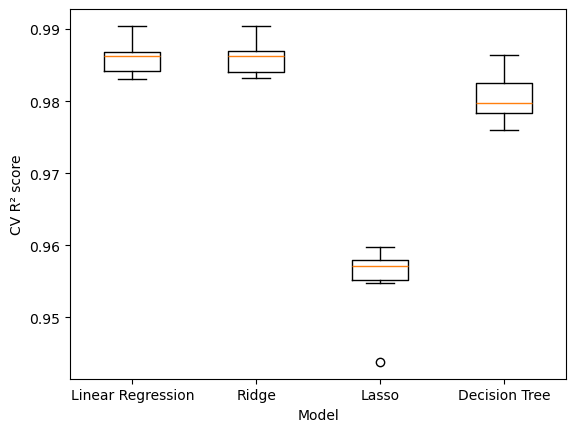

In [42]:
X_dum_train, X_dum_test, y_dum_train, y_dum_test = train_test_split(X_dummies, y_dummies, test_size=0.2, random_state= 1984)

linearReg = LinearRegression()
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1)
DecTreeReg = DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.02, random_state=1984)

models={"Linear Regression" : linearReg, "Ridge": ridge, "Lasso":lasso, "Decision Tree":DecTreeReg}

from combine_dataframes import visu_cv_score
visu_cv_score(models,X_dum_train,y_dum_train)

Linear regression and Ridge seem to be the best ones.  
## **Test performance**

In [43]:
from combine_dataframes import rmse_regression_models
rmse_regression_models(models,X_dum_train,y_dum_train,X_dum_test,y_dum_test)

Linear Regression Test set rmse: 0.9469209155815803
Ridge Test set rmse: 0.9471277814300852
Lasso Test set rmse: 2.0910821106433857
Decision Tree Test set rmse: 1.1605730026824967


Ridge and Linear Regression are very similar however, Linear Regression performs slightly better as its rmse is slightly smaller. 
I will try to see how the models respond to a standardization of the data.

In [44]:
scaler = StandardScaler()
X_dum_train_scaled = scaler.fit_transform(X_dum_train)
X_dum_test_scaled = scaler.fit_transform(X_dum_test)

rmse_regression_models(models, X_dum_train_scaled,y_dum_train, X_dum_test_scaled,y_dum_test)

Linear Regression Test set rmse: 1.1003533691416614
Ridge Test set rmse: 1.1001629085609061
Lasso Test set rmse: 1.2091326804679279
Decision Tree Test set rmse: 1.2360306087167376


By standardizing my data only Lasso performs better. 

In [45]:
Max_norm = MaxAbsScaler()
X_dum_train_norm = Max_norm.fit_transform(X_dum_train)
X_dum_test_norm = Max_norm.transform(X_dum_test)

rmse_regression_models(models, X_dum_train_norm,y_dum_train,X_dum_test_norm,y_dum_test)

Linear Regression Test set rmse: 0.9469209155815801
Ridge Test set rmse: 0.9469949212651358
Lasso Test set rmse: 1.979062695959314
Decision Tree Test set rmse: 1.1605730026824967


Normalizing to the maximum does not change much for the performance of the model.  
Hence, I will keep the original set.

## **Comparing the features importance with my EDA conclusion**  

The advantage of linear regression models is that we can see the importance of each feature for the model using the coeficient attribute (the slope of each linear regression). I can use that to see whether my conclusions and suggestions were valid.

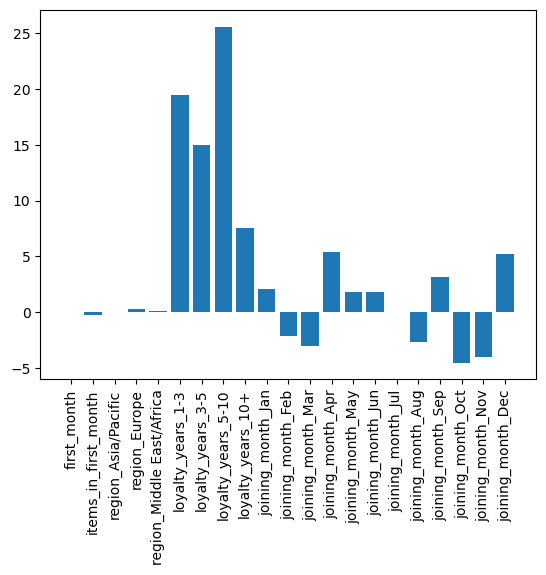

In [46]:
coef_LinearReg = linearReg.fit(X_dum_train, y_dum_train).coef_

names_features = customers_dummies.drop("spend", axis=1).columns

plt.bar(x=names_features, height=coef_LinearReg)
plt.xticks(rotation = 90)
plt.show()

Our team was right and wrong. The loyalty length 5-10 years is the most important predictor for 'spend'. However, after 10 years the coeficient decreases dramatically. Hence, this confirms what I was suggesting to improve it: offer a 10 yera anniversary big gift (relative to the amount the customer would have spend in the past 5 years).  
Also, like I was suspecting, the region seems not to have much of an impact. I wasn't sure so I kept the 'region' feature but like for 'promotion' I could potentially be able to remove it without affecting the performance. 
Furthermore, while the expenses on the first month also doesn't seem to have much impact, the joining_month and loyalty_years are the most important features. 

## **Testing Linear Regression on the second dataset**  
the second dataset is already cleaned. Furthermore, it doesn't contain any "Unknown" values in the feature joining_month.  
In the Datacamp excercise, I am supposed to use this second dataset to train the chosen model with in order to predict the 'spend' of the third dataset (does not contain any 'spend' column).  
I will therefore test whether Regression model is indeed a good algorithm for this dataset to use. If so, then I will fit the model and use it to predict the 'spend' in the third dataset.

### **Preprocessing the second and third dataset**

In [47]:
customer_train = pd.read_csv("train_data.csv")
customer_test = pd.read_csv("test_data.csv")
print(customer_train.info())
print(customer_train["joining_month"].value_counts())
print(customer_test["joining_month"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           996 non-null    int64  
 1   spend                 996 non-null    float64
 2   first_month           996 non-null    float64
 3   items_in_first_month  996 non-null    int64  
 4   region                996 non-null    object 
 5   loyalty_years         996 non-null    object 
 6   joining_month         996 non-null    object 
 7   promotion             996 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 62.4+ KB
None
joining_month
Jan    124
Jun     94
Mar     88
May     86
Feb     85
Jul     84
Apr     83
Nov     82
Oct     80
Sep     80
Aug     75
Dec     35
Name: count, dtype: int64
joining_month
Apr    35
Jan    35
May    28
Nov    28
Aug    22
Sep    20
Jun    18
Mar    18
Oct    17
Jul    15
Feb    10
Dec     4
Name: count,

In [48]:
print(len(customer_train[customer_train["first_month"] == 0]))
print(len(customer_test[customer_test["first_month"] == 0]))

0
0


In addition of no "Unknown" in joining_month there are also no null values in the first_month in both train and test dataset. 

<Axes: xlabel='promotion', ylabel='spend'>

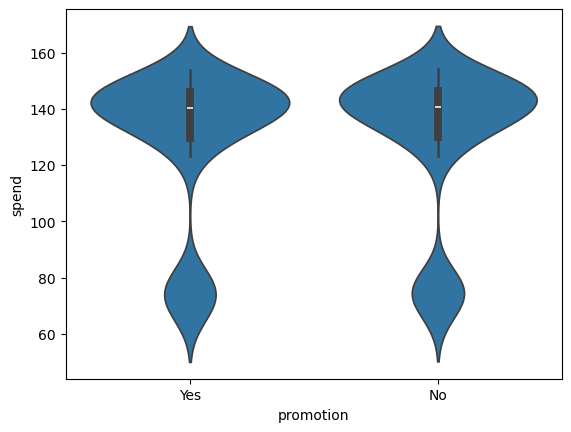

In [49]:
sns.violinplot(x="promotion", y="spend", data=customer_train)

We can see again in the second dataset no difference of the 'spend' distribution pattern between the 2 categories of the feature 'promotion'.  
I will therefore remove this feature. 

In [50]:
customer_train = customer_train.drop(["customer_id", "promotion"], axis=1)
customer_test = customer_test.drop(["customer_id", "promotion"], axis=1)

from combine_dataframes import to_datetime
to_datetime(customer_train,"joining_month","%b")
customer_train["joining_month"] = customer_train["joining_month"].dt.month
to_datetime(customer_test,"joining_month","%b")
customer_test["joining_month"] = customer_test["joining_month"].dt.month
print(customer_train["joining_month"].value_counts())

joining_month
1     124
6      94
3      88
5      86
2      85
7      84
4      83
11     82
10     80
9      80
8      75
12     35
Name: count, dtype: int64


### **Testing that linear Regression is also the best model**

In [51]:
dummies_customer_train = pd.get_dummies(customer_train, drop_first=True)
dummies_customer_test = pd.get_dummies(customer_test, drop_first=True)
print(dummies_customer_train.info())
print(dummies_customer_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spend                      996 non-null    float64
 1   first_month                996 non-null    float64
 2   items_in_first_month       996 non-null    int64  
 3   joining_month              996 non-null    int32  
 4   region_Asia/Pacific        996 non-null    bool   
 5   region_Europe              996 non-null    bool   
 6   region_Middle East/Africa  996 non-null    bool   
 7   loyalty_years_1-3          996 non-null    bool   
 8   loyalty_years_10+          996 non-null    bool   
 9   loyalty_years_3-5          996 non-null    bool   
 10  loyalty_years_5-10         996 non-null    bool   
dtypes: bool(7), float64(2), int32(1), int64(1)
memory usage: 34.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 

In [52]:
X_train = dummies_customer_train.drop("spend", axis=1).values
y_train = dummies_customer_train["spend"].values

X_test = dummies_customer_test.values

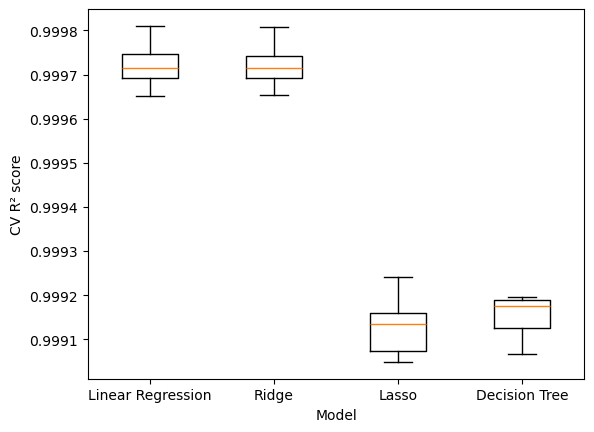

In [86]:
DecTreeReg = DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.08, random_state=1984)
visu_cv_score(models, X_train, y_train)

In [87]:
X_train_train,X_train_test,y_train_train,y_train_test = train_test_split(X_train,y_train,test_size=0.2, random_state=1984)

rmse_regression_models(models,X_train_train,y_train_train,X_train_test,y_train_test)


Linear Regression Test set rmse: 0.45788253962105047
Ridge Test set rmse: 0.45645250911838803
Lasso Test set rmse: 0.835627035556949
Decision Tree Test set rmse: 0.8127422063741221


We can see that with the second dataset as well, the Ridge model is this time slightly better than LinearRegression. 

### **Predictions of the test dataset with the Linear regression model and the second dataset**  
Following the DataCamp excersise, I am predicting the 'spend' of the test dataset with the Linear regression model and the second dataset to train the model.

In [ ]:
ridge.fit(X_train,y_train)
y_pred_linReg = ridge.predict(X_test)
customer_test["prediction spend_linReg"] = y_pred_linReg

# **Can we combine the two dataset to train the Linear Regression model?**  
 
Datacamp asked me to use the train dataset to train the model and use it to predict the 'spend' of the test dataset.  
However, in real life, how can I be confident of which dataset to use to train my model?  
Here, I am going to caompare the features distributions and their relationship with spend. You will see that their distribution patterns are completely different. This lead to a very poor performance of the model.  
Furthermore, combining the two datasets also makes the linear regression worse.  
To avoid this, the ensemble model BaggingRegressor is a very good compromise and as you will see at the end, its predictions show a very nice correlation with low variability with the predictions above made with the Linear regression model and the dataset corresponding to the perfect one for the test dataset.  
Overall, the linear regression overfits with the dataset it is fed with and therefore leads to a poor performance when making predictions with a dataset with complete different distribution patterns.

## **The "spend" in both datasets shows complete different distribution pattern** 

Text(0.5, 1.0, "Violin plot of 'spend")

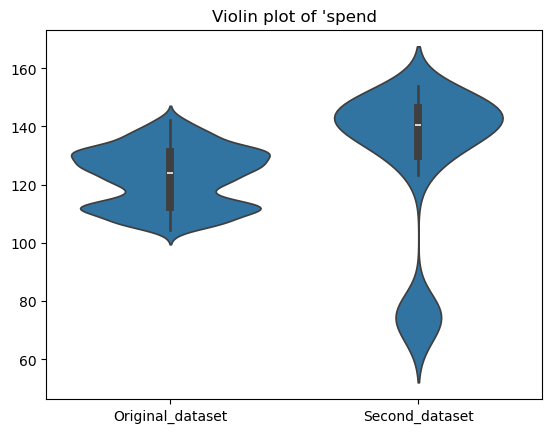

In [56]:
customer_data.name = "Original_dataset"
customer_train.name = "Second_dataset"
customer_test.name = "test_dataset"

spend = {"Dataset":[], "Spend":[]}
for item in customer_data["spend"]:
    spend["Dataset"].append(customer_data.name)
    spend["Spend"].append(item)

for item in customer_train["spend"]:
    spend["Dataset"].append(customer_train.name)
    spend["Spend"].append(item)

sns.violinplot(x=spend["Dataset"], y=spend["Spend"])
plt.title("Violin plot of 'spend")

## **Comparison of the distribution patterns of the numerical features**

### **Number of items in the first month**

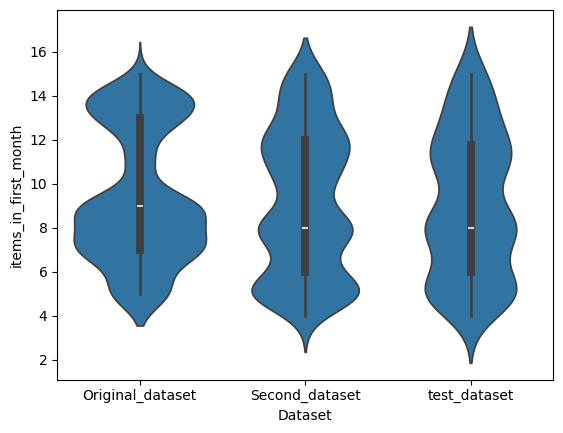

In [57]:
from combine_dataframes import orig_train_test_df

nb_items = orig_train_test_df(customer_data,customer_train,customer_test,"items_in_first_month")

sns.violinplot(x="Dataset", y="items_in_first_month", data=nb_items)
plt.show()



While the distribution of number of items is different in customer_train (second dataset) compared to the original customer_data, the distribution pattern is more similar to the test_dataset (customer_test), the one where we have to predict 'spend'. 

### **Loyalty years**

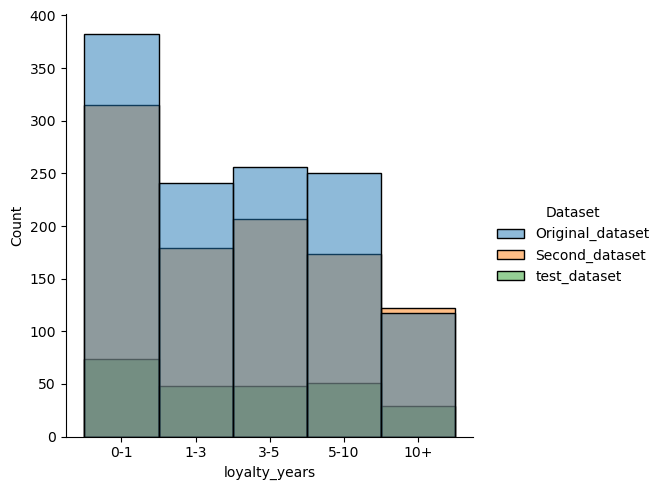

In [58]:
loyalty_year_df = orig_train_test_df(customer_data,customer_train,customer_test,"loyalty_years")

loyalty_year_df["loyalty_years"] = loyalty_year_df["loyalty_years"].astype("category")
loyalty_year_df["loyalty_years"] = loyalty_year_df["loyalty_years"].cat.reorder_categories(new_categories=["0-1","1-3","3-5","5-10","10+"], ordered=True)

sns.displot(x="loyalty_years", data=loyalty_year_df, hue="Dataset")
plt.show()

In [59]:
print(loyalty_year_df.groupby("Dataset")["loyalty_years"].value_counts(normalize=True))


Dataset           loyalty_years
Original_dataset  0-1              0.306581
                  3-5              0.205457
                  5-10             0.200642
                  1-3              0.193419
                  10+              0.093900
Second_dataset    0-1              0.316265
                  3-5              0.207831
                  1-3              0.179719
                  5-10             0.173695
                  10+              0.122490
test_dataset      0-1              0.296000
                  5-10             0.204000
                  1-3              0.192000
                  3-5              0.192000
                  10+              0.116000
Name: proportion, dtype: float64


In all datasets we have 0-1 the most frequent while 10+ are the least frequent. However, between the distribution is very different between the 3.  
This can be problemtaic because we know that the different loyal customers spend differently between the 2 dadasets. Especially for the 5-10 category. While they are not the ones that spend the most in the second dataset, they still spend more (median = 140) than the customers of the same category in the first dataset (median = 135). In the test Dataset this category is the most frequent after the 0-1 category. Hence, this could lead to an increaase of the prediction errors in this category if we do not choose the best sample to train the model.

### **Joining_month**

c:\Users\Angelique\Desktop\Test folder\DataCamp\practical sample\data science associate\EDA_exam_CodeOp\combine_dataframes.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_datetime(df[column_name], format=date_format)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_5152\1988645271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_unknown["joining_month"] = no_unknown["joining_month"].dt.month


<Axes: xlabel='joining_month', ylabel='Density'>

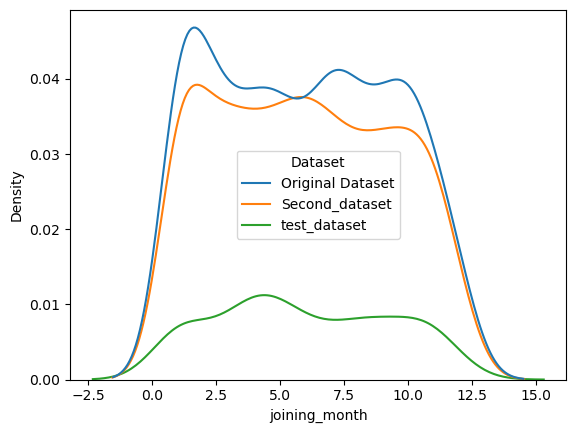

In [71]:
no_unknown = customer_data[customer_data["joining_month"] != "Unknown"]
to_datetime(no_unknown,"joining_month","%b")
no_unknown["joining_month"] = no_unknown["joining_month"].dt.month
no_unknown.name = "Original Dataset"
joining_month_df = orig_train_test_df(no_unknown,customer_train,customer_test,"joining_month")
sns.kdeplot(x="joining_month", data=joining_month_df, hue="Dataset")

The distribution of joining_month is also here different from the 2 other datasets.

## **What happens to the model performance when we train it with the first dataset and test it with the second dataset?**  

Here, I will demonstrate the overfitting of the linear regression model and how it does not perform well on datasets with different distributions.  
I am first removing the category "Unknown" from the feature "joining_month" as the second dataset doesn't have any "Unknown" category. I will then quickly confirm tht the Linear Regression is still appropriate for this dataset.  
Finally, I will train the model with hte first dataset and test the performance of the model with the second dataset.

In [61]:
#dummies
dummies_no_unknown = pd.get_dummies(no_unknown, drop_first=True)
print(dummies_no_unknown.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1121 entries, 0 to 1243
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spend                      1121 non-null   float64
 1   first_month                1121 non-null   float64
 2   items_in_first_month       1121 non-null   int64  
 3   joining_month              1121 non-null   int32  
 4   region_Asia/Pacific        1121 non-null   bool   
 5   region_Europe              1121 non-null   bool   
 6   region_Middle East/Africa  1121 non-null   bool   
 7   loyalty_years_1-3          1121 non-null   bool   
 8   loyalty_years_3-5          1121 non-null   bool   
 9   loyalty_years_5-10         1121 non-null   bool   
 10  loyalty_years_10+          1121 non-null   bool   
dtypes: bool(7), float64(2), int32(1), int64(1)
memory usage: 47.1 KB
None


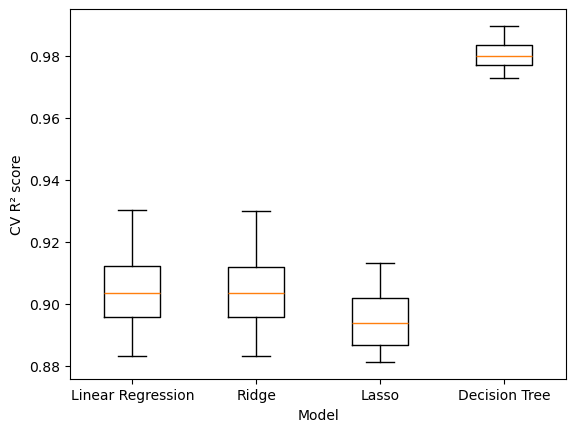

In [72]:
new_X = dummies_no_unknown.drop("spend", axis=1).values
new_y = dummies_no_unknown["spend"].values

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X,new_y, test_size=0.2, random_state=1984)

visu_cv_score(models,new_X_train,new_y_train)

In [74]:
rmse_regression_models(models,new_X_train,new_y_train,new_X_test,new_y_test)

Linear Regression Test set rmse: 3.037368372386412
Ridge Test set rmse: 3.0402765735344954
Lasso Test set rmse: 3.3606926316547527
Decision Tree Test set rmse: 1.2320113327437479


After removing "unknown", now the DecisionTreeRegressor seems to be a better fit. Note however that all the models performs less than ebfore (when "Unknown" was present and the joining_month taken as an object and not numbers)

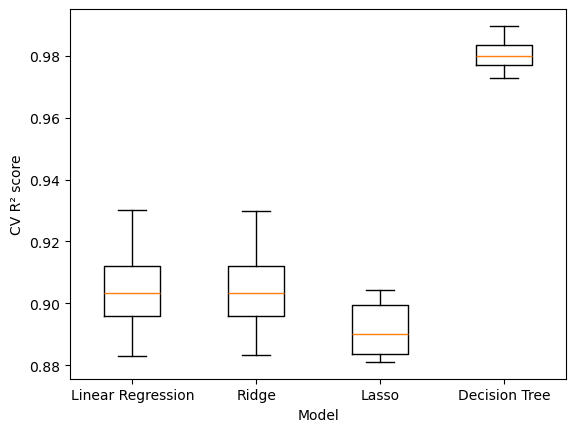

In [75]:
#Try with rescaling to the max
new_X_train_scaled = Max_norm.fit_transform(new_X_train)
new_X_test_scaled = Max_norm.transform(new_X_test)

visu_cv_score(models,new_X_train_scaled,new_y_train)

In [76]:
rmse_regression_models(models,new_X_train_scaled,new_y_train,new_X_test_scaled,new_y_test)

Linear Regression Test set rmse: 3.0373683723864104
Ridge Test set rmse: 3.0408401588512883
Lasso Test set rmse: 3.4948881869957336
Decision Tree Test set rmse: 1.2320113327437479


Normalisation doesn't change the fact that now, after removing the "unknown" values and switching the joining_month column to integer, Decision tree becomes the best model for the first dataaset. 

## **Testing the model performance of the model fit with the first dataset**
 

In [77]:
DecTreeReg.fit(new_X_train,new_y_train)
test_pred_mit1stData = DecTreeReg.predict(X_train_test)
rmse_decTree_1stDataset = MSE(y_train_test,test_pred_mit1stData) ** (1/2)
print(rmse_decTree_1stDataset)

31.093642201695857


The decision tree fit with the 1st dataset gives a very bad rmse (very large error). We have an overfitting.

## **Modelisation with both datasets**  
I will first concatenate both datasets mix the samples. I will do a cross-validation on Linear Regression, Ridge and Lasso (also linear regression + alpha parameter to avoid as much as possible overfitting) and a Decision Tree (for regression)

### **Concatenating both dataset and preprocessing them**

In [88]:
combined_dataset = pd.concat([dummies_no_unknown,dummies_customer_train])

dummies_combined = combined_dataset.sample(frac=1, replace=False, random_state=42)
print(dummies_combined.info())

X_combin = dummies_combined.drop("spend", axis=1).values
y_combin = dummies_combined["spend"].values

X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(X_combin,y_combin, test_size=0.3, random_state=1984)


<class 'pandas.core.frame.DataFrame'>
Index: 2117 entries, 454 to 957
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spend                      2117 non-null   float64
 1   first_month                2117 non-null   float64
 2   items_in_first_month       2117 non-null   int64  
 3   joining_month              2117 non-null   int32  
 4   region_Asia/Pacific        2117 non-null   bool   
 5   region_Europe              2117 non-null   bool   
 6   region_Middle East/Africa  2117 non-null   bool   
 7   loyalty_years_1-3          2117 non-null   bool   
 8   loyalty_years_3-5          2117 non-null   bool   
 9   loyalty_years_5-10         2117 non-null   bool   
 10  loyalty_years_10+          2117 non-null   bool   
dtypes: bool(7), float64(2), int32(1), int64(1)
memory usage: 88.9 KB
None


## **what is the best model for the combined dataset?**

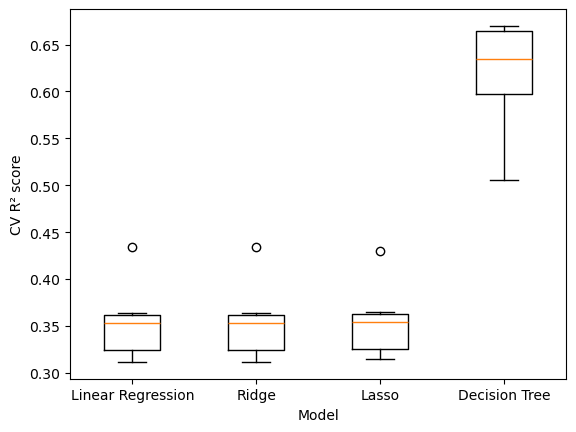

In [79]:

visu_cv_score(models,X_comb_train,y_comb_train)


In [80]:
rmse_regression_models(models,X_comb_train,y_comb_train,X_comb_test,y_comb_test)

Linear Regression Test set rmse: 16.709913650185793
Ridge Test set rmse: 16.709061239580517
Lasso Test set rmse: 16.64096994164528
Decision Tree Test set rmse: 13.276359572504392


Decision Tree seems much more appropriate. However, it is still not ideal.

## **Improving the Decision Tree model**

In [93]:
from sklearn.ensemble import RandomForestRegressor

RandForest = RandomForestRegressor(n_estimators=200, min_samples_leaf=0.08, random_state=1984)


In [94]:
from sklearn.ensemble import BaggingRegressor

baggReg = BaggingRegressor(n_estimators=200, n_jobs=-1, random_state=1984)


models_ensemble = {"Bagging Regressor":baggReg, "Random Forest":RandForest}
rmse_regression_models(models_ensemble,X_comb_train,y_comb_train,X_comb_test,y_comb_test)

Bagging Regressor Test set rmse: 5.548306070234234
Random Forest Test set rmse: 16.06788833968878


Bagging is a much better ensemble model.

## **Comparing predictions**  

Knowing that the second dataset was supposed to be the one to used to train the linear regression model to predict the test dataset, I am going know to test how effecient is bagging with the combined dataset. 

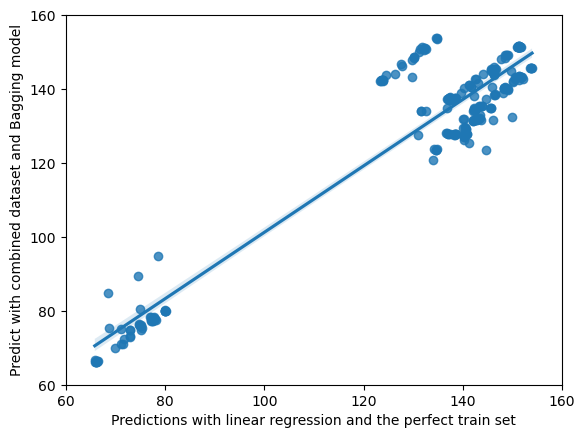

In [100]:

baggReg.fit(X_combin,y_combin)
test_pred_bagg = baggReg.predict(X_test)

predictions = {"predictions with train set": y_pred_linReg, "predictions with combi set":test_pred_bagg}
sns.regplot(x=predictions["predictions with train set"], y=predictions["predictions with combi set"])
plt.xlim(60,160)
plt.ylim(60,160)
plt.xlabel("Predictions with linear regression and the perfect train set")
plt.ylabel("Predict with combined dataset and Bagging model")
plt.show()

None (or perhaps almost) of the dots fits on the line indicating that I do not have any matches between the 2 prediction sets. However, they are pretty close.

In [107]:
predictions_df = pd.DataFrame(predictions)

from scipy.stats import wilcoxon

stat_wilcox, p_val_wilcox = wilcoxon(predictions_df["predictions with train set"],predictions_df["predictions with combi set"], zero_method="zsplit",nan_policy="raise")
print(stat_wilcox, p_val_wilcox)


10908.0 2.9665587581269554e-05


In [109]:
rse_pred = MSE(y_pred_linReg,test_pred_bagg) ** (1/2)
rse_pred

9.153493402019262

In [110]:
print(combined_dataset["spend"].describe())

count    2117.000000
mean      125.700874
std        20.027087
min        65.540000
25%       115.150000
50%       130.080000
75%       140.490000
max       154.050000
Name: spend, dtype: float64


# **Conclusion**  
I had in hand two datasets and one without the target (or dependent) variable. They both come from the same company *International Essentials*.
However, I do not know under which circumstances these datasets have been taken. I know from Datacamp that I should fit the model with the second dataset to predict the 'spend' (target variable) of the third one.  
However, in real life context, how can I decide on which dataset to choose?  
I found that Linear Regression overfit the data and Ridge does not improve that. That's because the two datasets hae different fetaures and target distributions patterns. Hence, a linear regression model will work very nicely with similar dataset. 
To compensate this problem, BaggingRegressor is a good compromise as it feeds the different algorithms (here 200) with unique bootstrap samples corresponding to the combined dataset (which would have been prealably mixed up without replacement).  
To have an idea of how big can we estimate the variation, I compared the predictions done with the best linear regression model (fed with the test dataset, the one I was supposed to use. The error is ~0.456) to the predictions obtained with the ensemble model Baggingegressor (fed with the combined dataset). I obtain an error of 9.15 which fits in the IQR of the combi 'spend'.  
Therefore this model is not ideal but it is not bad when we have two datasets with drastic different distributions and we do not know from which circumstances the third dataset has been taken.  
One way to choose a dataset would be to compare the features distributions between the three datasets and choose the dataset that shows closer patterns to the dataset we want to use to predict. By doing this, I found that indeed the second dataset is more apropriate (like Datacamp has told me). 